# Twitter Spam Classification 

### Importing necessary libraries for Exploratory Data Analysis and Model Building

In [1]:
import pandas as pd
import collections
import numpy as np
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
import scipy
import math
import nltk

np.set_printoptions(suppress=True)

%matplotlib inline

In [3]:
from sklearn.metrics import confusion_matrix

### Importing and preparing data

In [4]:
df_input_prefiltered = pd.read_csv('tweet_metadata.csv')
df = pd.read_csv('tweet_spam_label.csv')


#dataframe merge and assign corresponding label
df_input = pd.merge(df, df_input_prefiltered, on=['id'])



print(df_input.columns)

Index(['id', 'label', 'coordinates', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'lang', 'place', 'possibly_sensitive',
       'quote_id', 'retweet_count', 'retweet_id', 'retweet_screen_name',
       'source', 'text', 'tweet_url', 'user_created_at', 'user_id',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name', 'user_screen_name',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')


### Splitting tabular Data based on Spam/ Ham label 

In [5]:
ham_df = df_input[df_input.label == 0]
spam_df = df_input[df_input.label == 1]

ham_df = ham_df.sample(len(spam_df))
df = pd.concat([ham_df,spam_df])

In [6]:
print("Number of Spam tweets:",len(spam_df),"\n")
print("Number of Ham tweets:",len(ham_df))

Number of Spam tweets: 3624 

Number of Ham tweets: 3624


### Exploring existance of null values 

#### We observe that many features have null values, which need to be removed from the dataset 

In [7]:
df.isnull().sum()

id                               0
label                            0
coordinates                   7231
created_at                       0
hashtags                      5331
media                         6052
urls                          3440
favorite_count                   0
in_reply_to_screen_name       6540
in_reply_to_status_id         6732
in_reply_to_user_id           6532
lang                             0
place                         7102
possibly_sensitive            2874
quote_id                      6941
retweet_count                    0
retweet_id                    5612
retweet_screen_name           5612
source                           0
text                             0
tweet_url                        0
user_created_at                  0
user_id                          0
user_default_profile_image       0
user_description              2102
user_favourites_count            0
user_followers_count             0
user_friends_count               0
user_listed_count   

### Removing unnecessary labels

In [8]:
print("\nNumber of tweets with null coordinates:",df.coordinates.isnull().sum(),"\nHence, we remove this feature.")

del df['coordinates']


Number of tweets with null coordinates: 7231 
Hence, we remove this feature.


### Splitting tweet created time & suer created time 

In [9]:
print(df.created_at.head(1))
print("\nWe split tweets time stamp into Day, Month, Date, Hour, Min, Sec, Year\n")

11495    Tue May 17 14:06:53 +0000 2016
Name: created_at, dtype: object

We split tweets time stamp into Day, Month, Date, Hour, Min, Sec, Year



In [10]:
df['tweet_day'] = df.created_at.str.split(" ").str[0]
df['tweet_month'] = df.created_at.str.split(" ").str[1]
df['tweet_date'] = df.created_at.str.split(" ").str[2]
df['tweet_time'] = df.created_at.str.split(" ").str[3]
df['tweet_year'] = df.created_at.str.split(" ").str[5]
df = df.reset_index(drop=True)

df.drop(df.index[df[df.lang == 'in'].index[0]],inplace=True)

In [11]:
df['acc_created_day'] = df.user_created_at.str.split(" ").str[0]
df['acc_created_month'] = df.user_created_at.str.split(" ").str[1]
df['acc_created_date'] = df.user_created_at.str.split(" ").str[2]
df['acc_created_time'] = df.user_created_at.str.split(" ").str[3]
df['acc_created_year'] = df.user_created_at.str.split(" ").str[5]

## Extracting Features

### has_hashtag is a binary variable. If the tweet was posted along with a hashtag, has_hastag = 1, else 0 
### num_hashtag is a continous variable. If takes the value corresponding to number of hashtags included in a tweet.

In [12]:
#HASHTAGS FEATURES

df['hashtags']=df['hashtags'].fillna(0)

has_hashtags = []
num_hashtags = []

for i in range(0,len(df)):
    if(df.hashtags.iloc[i] == 0):
        has_hashtags.append(0)
        num_hashtags.append(0)
    else:
        has_hashtags.append(1)
        num_hashtags.append(len(df.hashtags.iloc[i].split(" ")))
    
df['has_hashtags'] = has_hashtags
df['num_hashtags'] = num_hashtags

### has_media is a binary variable. If the tweet was posted along with a media link, has_media = 1, else 0

In [13]:
#MEDIA 

df['media'] = df['media'].fillna(0)

has_media = []

for i in range(0,len(df)):
    if(df.media.iloc[i] == 0):
        has_media.append(0)
    else:
        has_media.append(1)

df['has_media'] = has_media

### has_urls is a binary variable. If the tweet consists a url link, has_url = 1, else 0 

In [14]:
#URLS

df['urls'] = df['urls'].fillna(0)

has_urls = []

for i in range(0,len(df)):
    if(df.urls.iloc[i] == 0):
        has_urls.append(0)
    else:
        has_urls.append(1)

df['has_urls'] = has_urls

### has_favorite_count is a binary variable. If the posted tweet contains a favourtie count, 
### has_favorite_count = 1, else 0 

In [15]:
#favorite_count

has_favorite_count = []

for i in range(0,len(df)):
    if(df.favorite_count.iloc[i] == 0):
        has_favorite_count.append(0)
    else:
        has_favorite_count.append(1)

df['has_favorite_count'] = has_favorite_count

### Deleteing language label as all the posted tweets are in English 

In [16]:
#lang, as they are all en, we can drop them

del df['lang']

### has_place is a binary variable. If the posted tweet contains location details along with it, has_place = 1, else 0

In [17]:
#place

has_place = []

df['place'] = df['place'].fillna(0)

for i in range(0,len(df)):
    if(df.place.iloc[i] == 0):
        has_place.append(0)
    else:
        has_place.append(1)
    
df['has_place'] = has_place

###  has_retweet_count is a binary variable. If the posted tweet contains retweet count, 
### has_retweet_count = 1, else 0

In [18]:
#retweet_count

has_retweet_count = []

for i in range(0,len(df)):
    if(df.retweet_count.iloc[i] == 0):
        has_retweet_count.append(0)
    else:
        has_retweet_count.append(1)
    
df['has_retweet_count'] = has_retweet_count

### is_RT is a binary variable. If the tweet id is a retweet of another tweet, is_RT = 1, else 0

In [19]:
is_RT = []

for i in range(0,len(df)):
    if(df.text.iloc[i][:2] == "RT"):
        is_RT.append(1)
    else:
        is_RT.append(0)
        
df['is_RT'] = is_RT

### Similarly, we check if a posted tweet has user description, has a follower count, has a user name, and is verified.

### All the corresponding values = 1, if the labels exist, else 0

In [20]:
df['has_user_description']=df.user_description.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_followers_count']=df.user_followers_count.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_listed_count']=df.user_listed_count.apply( lambda x: 0 if pd.isnull(x) else 1)
df['has_user_name']=df.user_name.apply( lambda x: 0 if pd.isnull(x) else 1)
df['is_user_verfied']= df.user_verified.apply(lambda x: 1 if x is True else 0 )

### f_ratio: The ratio of followers to following of a person, which is important in analysis Spam/ Ham tweets

In [21]:
df['f_ratio'] = (df['user_followers_count']+1)/(df['user_followers_count']+1 + df['user_friends_count']+1)

### length is a continuous variable, corresponding to number of words in a given tweet 

In [22]:
length = []
for i in range(0,len(df)):
    length.append(len(df.iloc[i].text))
df['length'] = length

###  DIGITS is a continuous variable, corresponds to number of digits in a given tweet

In [23]:
digits_list = []

for i in range(0,len(df)):
    if(sum(c.isdigit() for c in df.text.iloc[i]) == 0):
        digits_list.append(0)
    else:
        digits_list.append(sum(c.isdigit() for c in df.text.iloc[i]))

digits_col = pd.Series(digits_list)
df['DIGITS'] = digits_col.values

### CAP is a continuous variable, coreesponds to number of capitalized words in a given tweet.

In [24]:
cap_list = []

for i in range(0,len(df)):
    words = df.text.iloc[i].split()
    count = 0
    for j in range(0,len(words)):
        if(words[j].isupper()):
            count = count + 1;
    cap_list.append(count)    
    #print(cap_list)
        
cap_col = pd.Series(cap_list)
df['CAP'] = cap_col.values

## Exploratory Data Analysis 

### First, we  take a look at the difference between the tweets corresponding to Spam & Ham. We create new feaures called filtered_text and filtered_text_lower. 

### filtered_text contains the text of every corresponding tweet, filtered by the nltk stopwords.

### filtered_text_lower contains tokens after converting the filtered_text to lower case

In [25]:
from nltk.corpus import stopwords
filtered_text = []

for i in range(0,len(df)):
    word_list = str(df.text.iloc[i]).split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    filtered_text.append(' '.join(filtered_words))
df['filtered_text'] = filtered_text
df['filtered_text_lower'] = df['filtered_text'].str.lower()

In [26]:
df.columns

# saving preprocessed tweets for training
df.to_csv('training_data.csv', index=False)

### Word Frequencies 

In [27]:
spam_text = []
spam_df = df[df.label==1]

for i in range(0,len(spam_df)):
    spam_text.append(spam_df.filtered_text.iloc[i])
    
ham_text = []
ham_df = df[df.label==0]

for i in range(0,len(ham_df)):
    ham_text.append(ham_df.filtered_text.iloc[i])


Below is the plot of 50 most commonly used words in SPAM comment


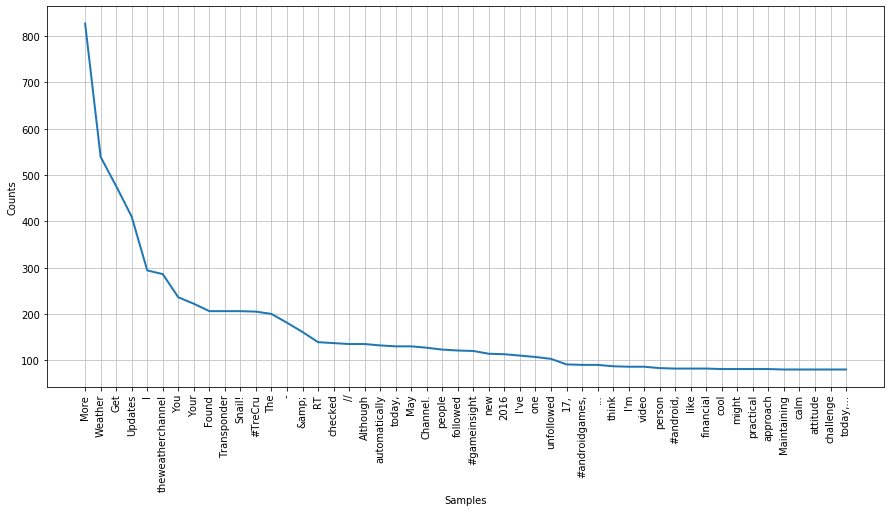


Below is the plot of 50 most commonly used words in HAM comment


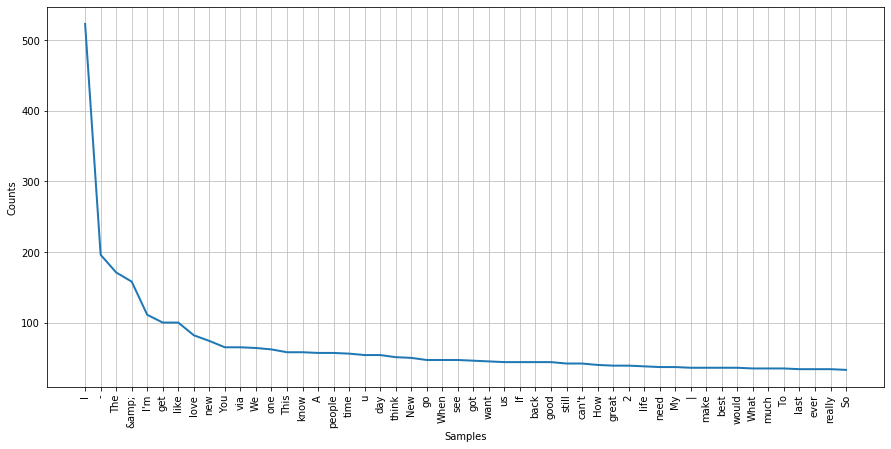

In [28]:
spam_text = ' '.join(spam_text).split()
freq = nltk.FreqDist(spam_text)

print("\nBelow is the plot of 50 most commonly used words in SPAM comment")
plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

ham_text = ' '.join(ham_text).split()
freq = nltk.FreqDist(ham_text)
print("\nBelow is the plot of 50 most commonly used words in HAM comment")

plt.figure(figsize=(15,7))
freq.most_common(50)
freq.plot(50)

### Function to return ngram words 

from itertools import combinations
from collections import Counter

def ngram(lines,i):
    pair_counter = Counter()
    for line in lines:
        unique_tokens = sorted(set(line))  
        combos = combinations(unique_tokens, i)
        pair_counter += Counter(combos)
    return pair_counter

### Applying 1-gram, bi-gram and tri-gram models on Spam corpus 

spam_df = df[df.label==1]
ham_df = df[df.label==0]

lines = []
for i in range(0,len(spam_df)):
    tokens = spam_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)

one_gram_spam = ngram(lines,1)
bi_gram_spam = ngram(lines,2)
tri_gram_spam = ngram(lines,3)

### Applying 1-gram, bi-gram and tri-gram models on Ham corpus 

lines = []
for i in range(0,len(ham_df)):
    tokens = ham_df.filtered_text_lower.iloc[i].split()
    lines.append(tokens)
    
one_gram_ham = ngram(lines,1)
bi_gram_ham = ngram(lines,2)
tri_gram_ham = ngram(lines,3)

### Top 25 word occurances in Spam tweets (1-gram, bi-gram & tri-gram models) 

one_gram_spam.most_common(20)

bi_gram_spam.most_common(20)

tri_gram_spam.most_common(20)

### Top 25 word occurances in Ham tweets (1-gram, bi-gram & tri-gram models)

one_gram_ham.most_common(20)

bi_gram_ham.most_common(20)

tri_gram_ham.most_common(20)

### Word Clouds for Spam corpus

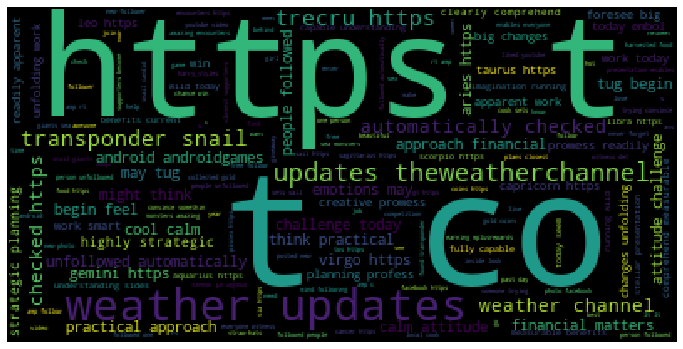

In [29]:
text = ''
for i in range(0,len(spam_df)):
    text = text + str(spam_df.filtered_text_lower.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Word Clouds for Ham corpus 

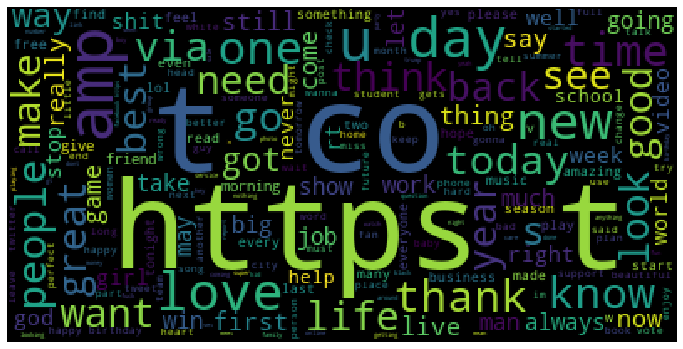

In [30]:
text = ''
for i in range(0,len(ham_df)):
    text = text + str(ham_df.filtered_text_lower.iloc[i])
    
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt

plt.figure(figsize=(12,9))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Sentimental Analysis of each tweet 
and how the sentiment changes in spam and ham

## Polarity vs Objectivity

Sentiment Analysis: the process of computationally identifying and categorizing opinions expressed in a piece of text, especially in order to determine whether the writer's attitude towards a particular topic, product, etc. is positive, negative, or neutral.

In [31]:
from textblob import TextBlob

polarity=[]
subjectivity=[]
sentiment_flag=[]
subjectivity_flag=[]
for i in df.filtered_text_lower:
    testimonial = TextBlob(i).sentiment
    polarity.append(testimonial.polarity)
    subjectivity.append(testimonial.subjectivity)
    
    if testimonial.polarity>0.33:
        sentiment_flag.append('positive')
    elif testimonial.polarity<-0.33:
        sentiment_flag.append('negative')
    else:
        sentiment_flag.append('neutral')
        
    if testimonial.subjectivity>0.66:
        subjectivity_flag.append('subjective')
    elif testimonial.subjectivity<0.33:
        subjectivity_flag.append('objective')
    else:
        subjectivity_flag.append('neutral')
            

            
print("The polarity score is a float within the range [-1.0, 1.0]. \nThe subjectivity is a float within the range [0.0, 1.0] \nwhere 0.0 is very objective and 1.0 is very subjective.")            
df['polarity']=pd.Series(polarity)
df['subjectivity']=pd.Series(subjectivity)
df['sentiment_flag']=pd.Series(sentiment_flag)
df['subjectivity_flag']=pd.Series(subjectivity_flag)
df[['polarity','subjectivity','sentiment_flag','subjectivity_flag']].head()

The polarity score is a float within the range [-1.0, 1.0]. 
The subjectivity is a float within the range [0.0, 1.0] 
where 0.0 is very objective and 1.0 is very subjective.


,polarity,subjectivity,sentiment_flag,subjectivity_flag
0,0.000000,0.000000,neutral,objective
1,0.200000,0.300000,neutral,objective
2,0.136364,0.454545,neutral,neutral
3,0.800000,0.700000,positive,subjective
4,-0.875000,0.666667,negative,subjective


## Polarity and Subjectivity in Spam and Ham

C:\Users\Yongjian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


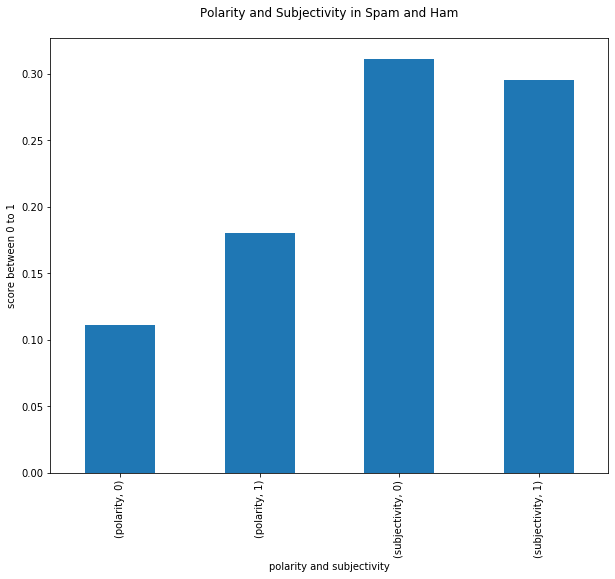

In [32]:
plt.figure(figsize=(10,8))
res=df.groupby(['label'])['polarity','subjectivity'].mean()
res.unstack(level=0).plot(kind='bar')
plt.ylabel("score between 0 to 1")
plt.xlabel("polarity and subjectivity")
plt.title("Polarity and Subjectivity in Spam and Ham\n")
plt.show()

## Sentiment in Spam and Ham

<Figure size 720x576 with 0 Axes>

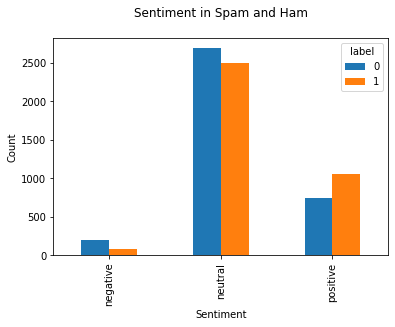

In [33]:
plt.figure(figsize=(10,8))
res= df.groupby(['label','sentiment_flag'])['filtered_text_lower'].count()
res.unstack(level=0).plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Sentiment")
plt.title("Sentiment in Spam and Ham\n")
plt.show()

## Subjectivity in Spam and Ham

<Figure size 720x576 with 0 Axes>

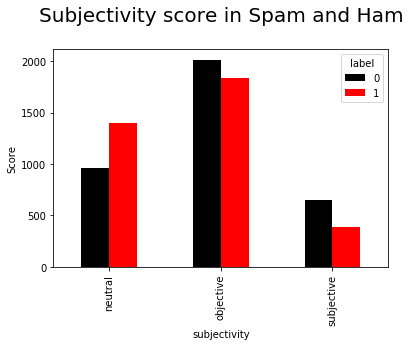

In [34]:
plt.figure(figsize=(10,8))
res= df.groupby(['label','subjectivity_flag'])['filtered_text_lower'].count()
res.unstack(level=0).plot(kind='bar',color=['black','red'])
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.ylabel("Score")
plt.xlabel("subjectivity")
plt.title("Subjectivity score in Spam and Ham\n")
plt.show()

## Subjectivity and Polarity in Spam and Ham

C:\Users\Yongjian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


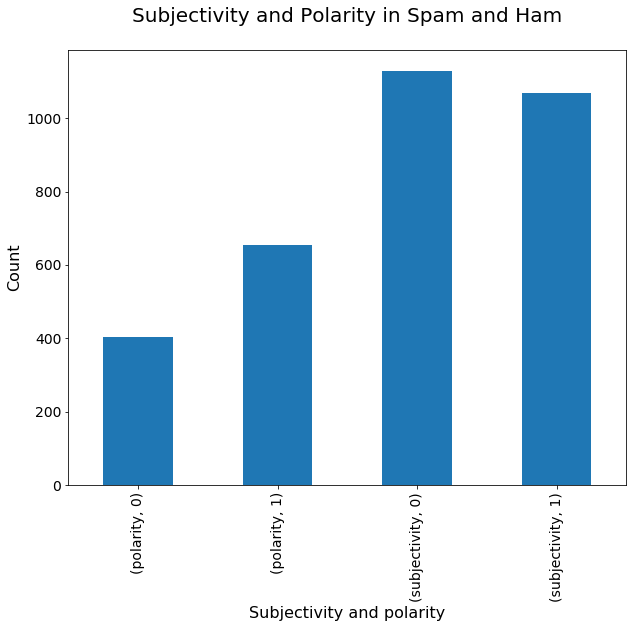

In [35]:
plt.figure(figsize=(10,8))
res= df.groupby(['label'])['polarity','subjectivity'].sum()
res.unstack(level=0).plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Subjectivity and polarity")
plt.title("Subjectivity and Polarity in Spam and Ham\n")
plt.show()

## Distribution of Polarity value in ham and spam

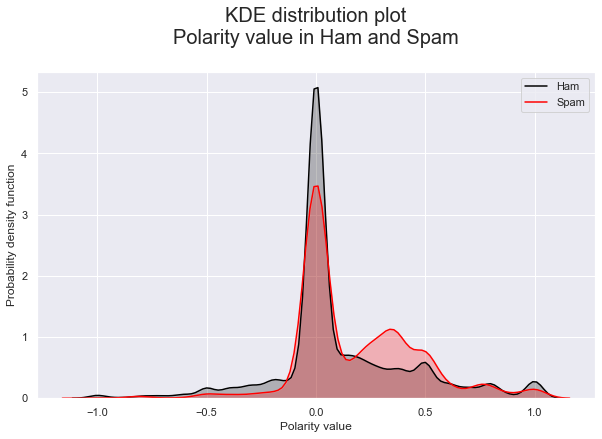

In [36]:
import seaborn as sns


sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(10,6)})
res=[x for x in list(df[df.label==0].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Ham",color='black');
res=[x for x in list(df[df.label==1].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Spam",color='red');

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)



plt.title("KDE distribution plot\nPolarity value in Ham and Spam\n")
plt.xlabel("Polarity value")
plt.ylabel("Probability density function")
plt.show()

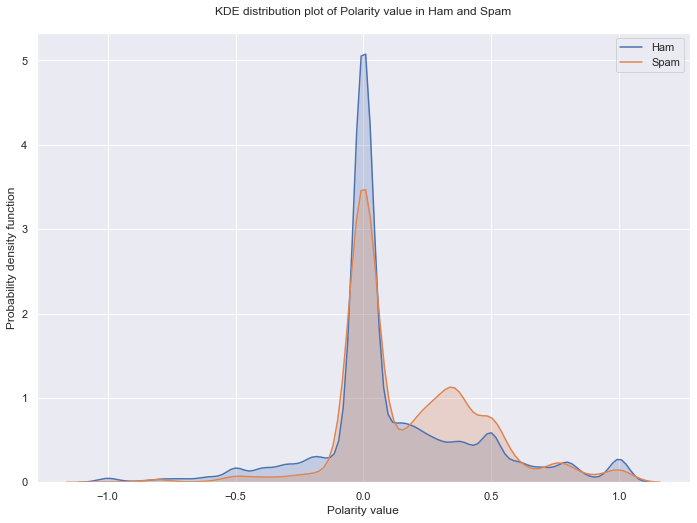

In [37]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(11.7,8.27)})
res=[x for x in list(df[df.label==0].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Ham");
res=[x for x in list(df[df.label==1].polarity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Spam");
plt.title("KDE distribution plot of Polarity value in Ham and Spam\n")
plt.xlabel("Polarity value")
plt.ylabel("Probability density function")
plt.show()

## Distribution of Subjectivity value in ham and spam

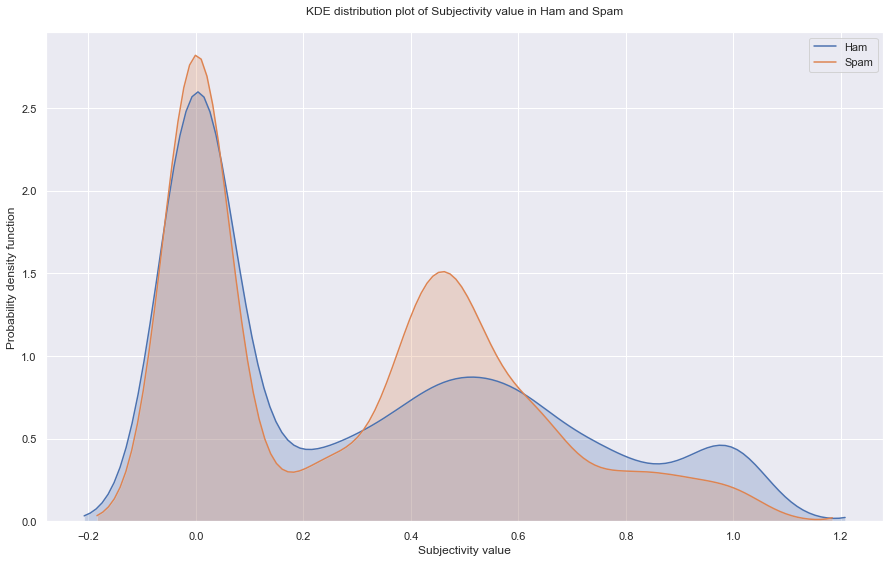

In [38]:
import seaborn as sns
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(15,9)})
res=[x for x in list(df[df.label==0].subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Ham");
res=[x for x in list(df[df.label==1].subjectivity) if str(x) != 'nan']
#sns.distplot(res)
sns.kdeplot(res, shade=True,label="Spam");
plt.title("KDE distribution plot of Subjectivity value in Ham and Spam\n")
plt.xlabel("Subjectivity value")
plt.ylabel("Probability density function")
plt.show()

## Top words in positive sentiment spam tweet

In [39]:
text_corpus= ''
import string 

for i in df[df.label==1][df.sentiment_flag=='positive']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in positive sentiment spam tweets")
allWordDist.most_common(10)

C:\Users\Yongjian\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Top words in positive sentiment spam tweets


[('https', 1071),
 ('...', 416),
 ('more', 402),
 ('today', 125),
 ('win', 110),
 ('may', 91),
 ('amp', 89),
 ('follow', 73),
 ('transponder', 68),
 ('snail', 68)]

## Top words in negative sentiment spam tweets

In [40]:
text_corpus= ''
for i in df[df.label==1][df.sentiment_flag=='negative']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in negative sentiment spam tweets")
allWordDist.most_common(10)

Top words in negative sentiment spam tweets


C:\Users\Yongjian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


[('https', 88),
 ("'s", 25),
 ('transponder', 17),
 ('snail', 17),
 ('trecru', 17),
 ('inside', 16),
 ('secret', 12),
 ('what', 9),
 ('mystery', 9),
 ('barrel', 9)]

## Top words in neutral sentiment spam tweets

In [41]:


text_corpus= ''
for i in df[df.label==1][df.sentiment_flag=='neutral']['filtered_text_lower']:
    text_corpus += i
    
allWords = nltk.tokenize.word_tokenize(text_corpus)
allWordDist = nltk.FreqDist(w.lower() for w in allWords if w not in list(string.punctuation))

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords )
print("Top words in neutral sentiment spam tweets")
allWordDist.most_common(10)



C:\Users\Yongjian\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


Top words in neutral sentiment spam tweets


[('https', 2135),
 ('...', 525),
 ('weather', 477),
 ('more', 426),
 ('updates', 361),
 ('theweatherchannel', 250),
 ('i', 205),
 ('the', 159),
 ('today', 136),
 ('transponder', 121)]

# Feature Selection 

In [42]:
df.columns

Index(['id', 'label', 'created_at', 'hashtags', 'media', 'urls',
       'favorite_count', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'place', 'possibly_sensitive', 'quote_id',
       'retweet_count', 'retweet_id', 'retweet_screen_name', 'source', 'text',
       'tweet_url', 'user_created_at', 'user_id', 'user_default_profile_image',
       'user_description', 'user_favourites_count', 'user_followers_count',
       'user_friends_count', 'user_listed_count', 'user_location', 'user_name',
       'user_screen_name', 'user_statuses_count', 'user_time_zone',
       'user_urls', 'user_verified', 'tweet_day', 'tweet_month', 'tweet_date',
       'tweet_time', 'tweet_year', 'acc_created_day', 'acc_created_month',
       'acc_created_date', 'acc_created_time', 'acc_created_year',
       'has_hashtags', 'num_hashtags', 'has_media', 'has_urls',
       'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT',
       'has_user_description', 'has_user_foll

# Summary Statistics

In [43]:
df[['f_ratio','length', 'DIGITS', 'CAP','num_hashtags','user_favourites_count','user_listed_count']].describe()

,f_ratio,length,DIGITS,CAP,num_hashtags,user_favourites_count,user_listed_count
count,7247.000000,7247.000000,7247.000000,7247.000000,7247.000000,7.247000e+03,7247.000000
mean,0.529258,91.070098,2.851111,0.622326,0.508624,1.640014e+04,95.908652
std,0.270216,35.954130,3.613396,1.480637,1.111206,5.069870e+04,1528.431376
min,0.005291,4.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,0.324654,58.000000,0.000000,0.000000,0.000000,7.000000e+00,0.000000
50%,0.509732,99.000000,2.000000,0.000000,0.000000,9.890000e+02,4.000000
75%,0.719845,123.000000,4.000000,1.000000,1.000000,1.098850e+04,24.000000
max,0.999998,188.000000,51.000000,27.000000,12.000000,1.425570e+06,117970.000000


### We conduct a series of hypothesis tests we include features which show statistical significance between Ham and Spam classes

In [44]:
from scipy import stats
np.set_printoptions(suppress=True)

print("t tests for continuous variables")

list_continous_variables=['f_ratio','length', 'DIGITS', 'CAP','num_hashtags','user_favourites_count']

for i in list_continous_variables:
    print("\nVariable name:",i)
    test = stats.ttest_ind(df[i],df['label'], equal_var = False)
    #print(test)
    if test.pvalue<0.05:
        print("The variable",i,"is significant, with a t-stat of",test.statistic)
    else:
        print("The variable",i,"is not significant")

t tests for continuous variables

Variable name: f_ratio
The variable f_ratio is significant, with a t-stat of 4.392479606638501

Variable name: length
The variable length is significant, with a t-stat of 214.42406069474518

Variable name: DIGITS
The variable DIGITS is significant, with a t-stat of 54.86941774621783

Variable name: CAP
The variable CAP is significant, with a t-stat of 6.667194464455955

Variable name: num_hashtags
The variable num_hashtags is not significant

Variable name: user_favourites_count
The variable user_favourites_count is significant, with a t-stat of 27.536999895748675


In [45]:
df = df[['label','has_hashtags', 'num_hashtags', 'has_media','user_favourites_count',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_followers_count',
       'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
       'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower','user_listed_count']]





# Index(['id', 'label', 'created_at', 'hashtags', 'media', 'urls',
#        'favorite_count', 'in_reply_to_screen_name', 'in_reply_to_status_id',
#        'in_reply_to_user_id', 'place', 'possibly_sensitive', 'quote_id',
#        'retweet_count', 'retweet_id', 'retweet_screen_name', 'source', 'text',
#        'tweet_url', 'user_created_at', 'user_id', 'user_default_profile_image',
#        'user_description', 'user_favourites_count', 'user_followers_count',
#        'user_friends_count', 'user_listed_count', 'user_location', 'user_name',
#        'user_screen_name', 'user_statuses_count', 'user_time_zone',
#        'user_urls', 'user_verified', 'tweet_day', 'tweet_month', 'tweet_date',
#        'tweet_time', 'tweet_year', 'acc_created_day', 'acc_created_month',
#        'acc_created_date', 'acc_created_time', 'acc_created_year',
#        'has_hashtags', 'num_hashtags', 'has_media', 'has_urls',
#        'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT',
#        'has_user_description', 'has_user_followers_count',
#        'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
#        'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower',
#        'polarity', 'subjectivity', 'sentiment_flag', 'subjectivity_flag'],
#       dtype='object')

## We plot distribution plots for continuous variables 

### Distribution plot for number of digits that occured in a tweet, based on Spam/ Ham label

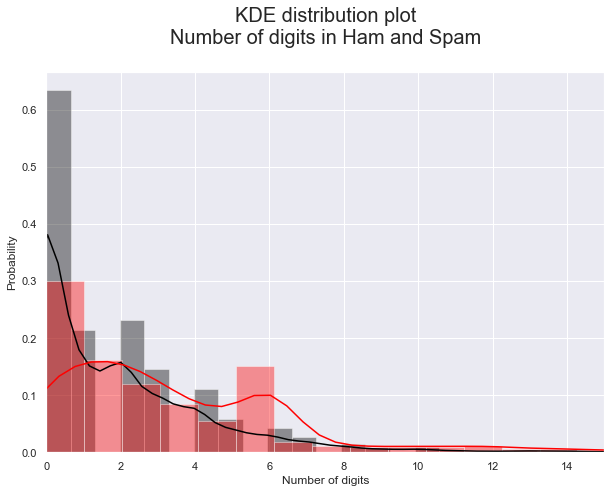

In [46]:
plt.figure(figsize=(10,7))
sns.distplot(df[df.label==0].DIGITS,color="black",kde=True,label="Ham");
sns.distplot(df[df.label==1].DIGITS,color="red",kde=True,label="Spam");
plt.xlim(0,15)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)



plt.title("KDE distribution plot\nNumber of digits in Ham and Spam\n")
plt.xlabel("Number of digits")
plt.ylabel("Probability")
plt.show()

plt.show()

### Distribution plot for number of capitalized words that occured in a tweet, based on Spam/ Ham label 

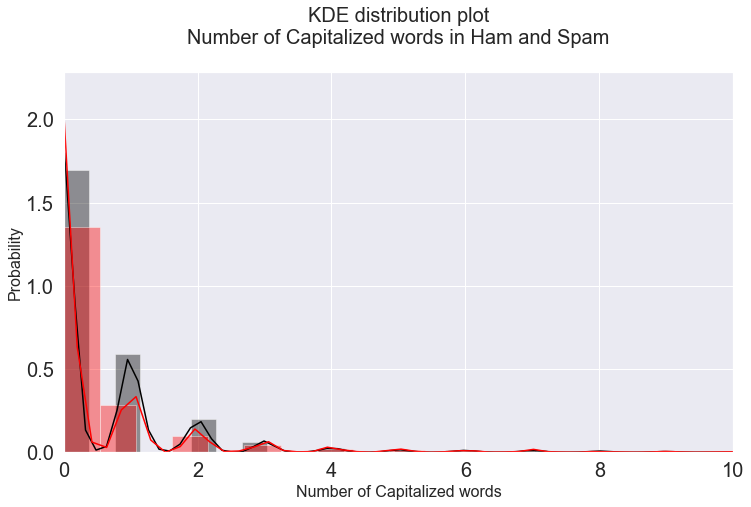

In [47]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].CAP,color="black",kde=True)
sns.distplot(df[df.label==1].CAP,color="red",kde=True)
plt.xlim(0,10)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)



plt.title("KDE distribution plot\nNumber of Capitalized words in Ham and Spam\n")
plt.xlabel("Number of Capitalized words")
plt.ylabel("Probability")
plt.show()

plt.show()

plt.show()

###  Distribution plot for f_ratio of a user, based on Spam/ Ham label

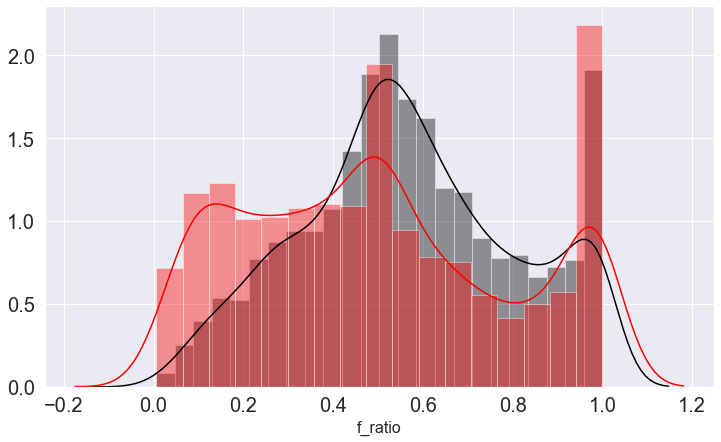

In [48]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].f_ratio,color="black",kde=True)
sns.distplot(df[df.label==1].f_ratio,color="red",kde=True)
plt.show()

### Distribution plot for number of hashtags in a tweet, based on Spam/ Ham labe 

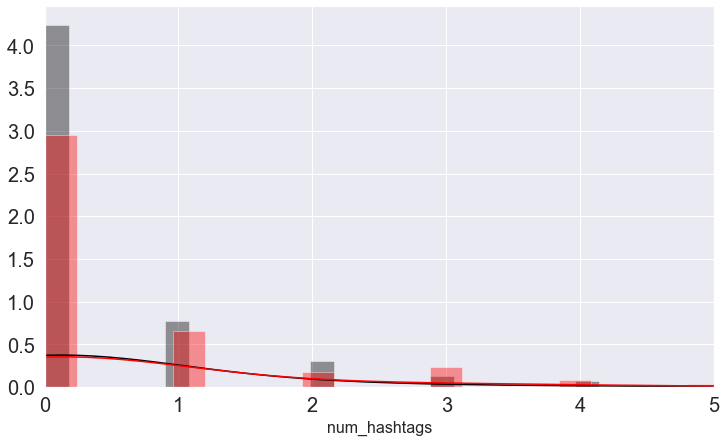

In [49]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].num_hashtags,color="black",kde_kws={'bw': 0.9})
sns.distplot(df[df.label==1].num_hashtags,color="red",kde_kws={'bw': 0.9})
plt.xlim(0,5)
plt.show()

### Distribution plot for number of times a user liked a tweet, based on Spam/ Ham label

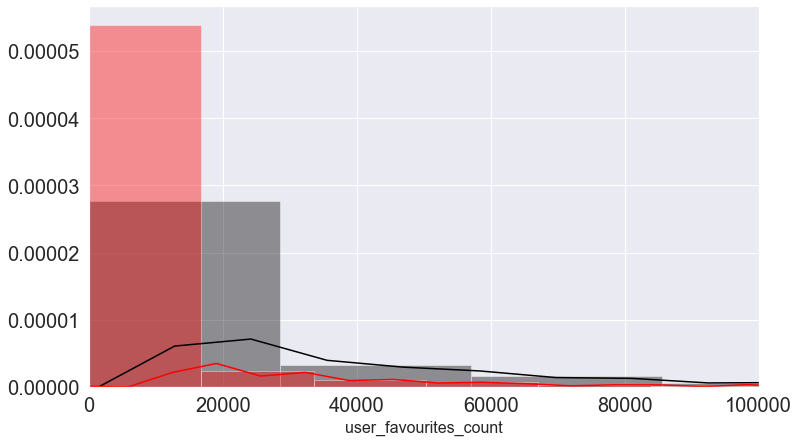

In [50]:
plt.figure(figsize=(12,7))
sns.distplot(df[df.label==0].user_favourites_count,color="black",kde=True)
sns.distplot(df[df.label==1].user_favourites_count,color="red",kde=True)
plt.xlim(0,100000)
plt.show()

### Distribution plot of Length of tweets, based on the Spam or Ham label 

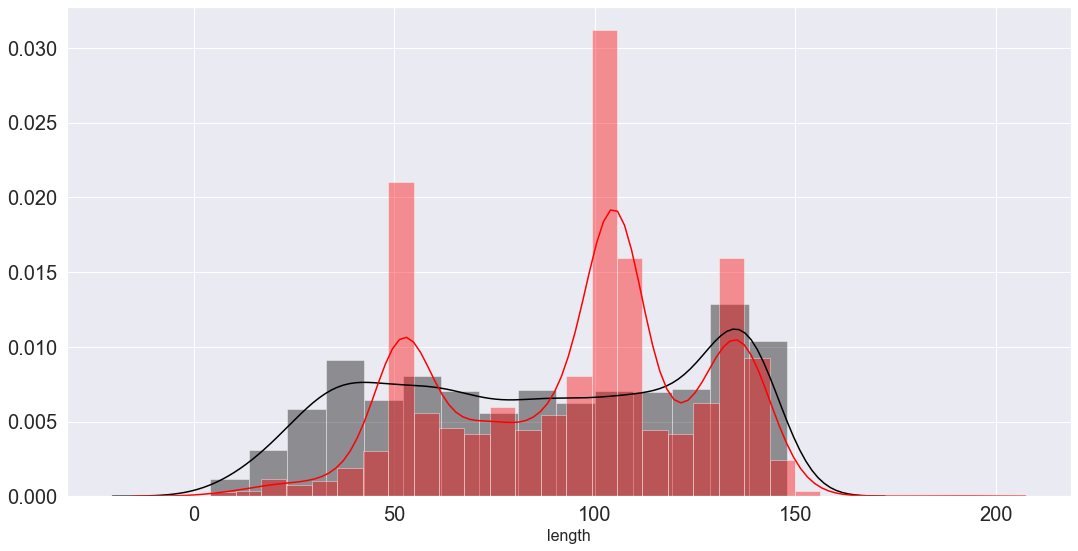

In [51]:
plt.figure(figsize=(18,9))
sns.distplot(df[df.label==0].length,color="black",kde=True)
sns.distplot(df[df.label==1].length,color="red",kde=True)
plt.show()

### Distribution plot of count of number of lists user is mentioned in, based on the Spam or Ham label 

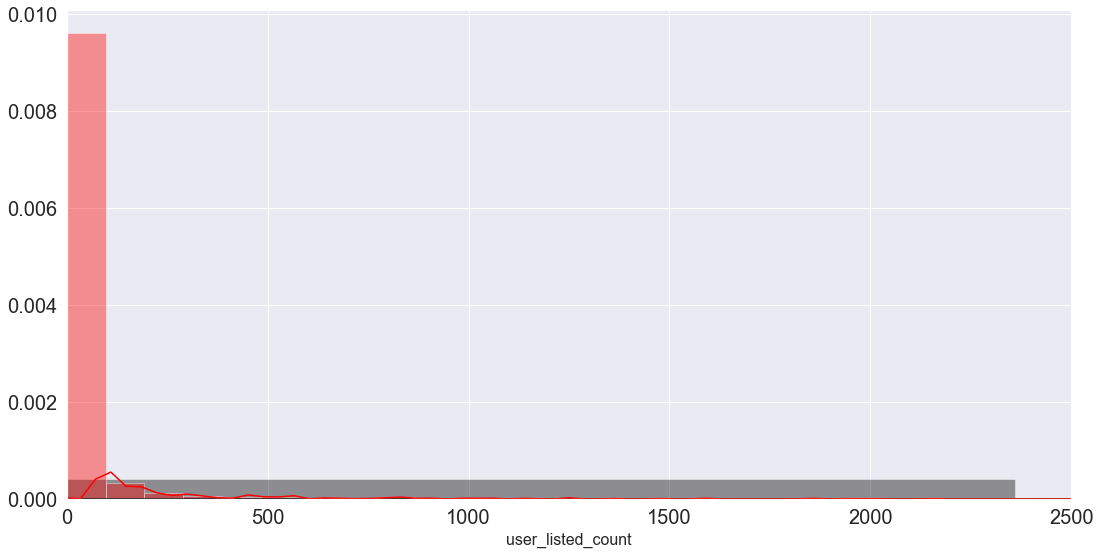

In [52]:
plt.figure(figsize=(18,9))
sns.distplot(df[df.label==0].user_listed_count,color="black",kde=True)
sns.distplot(df[df.label==1].user_listed_count,color="red",kde=True)
plt.xlim(0,2500)
plt.show()

Count plot for ' has_hashtags ' feature, based on Spam/ Ham tweet label


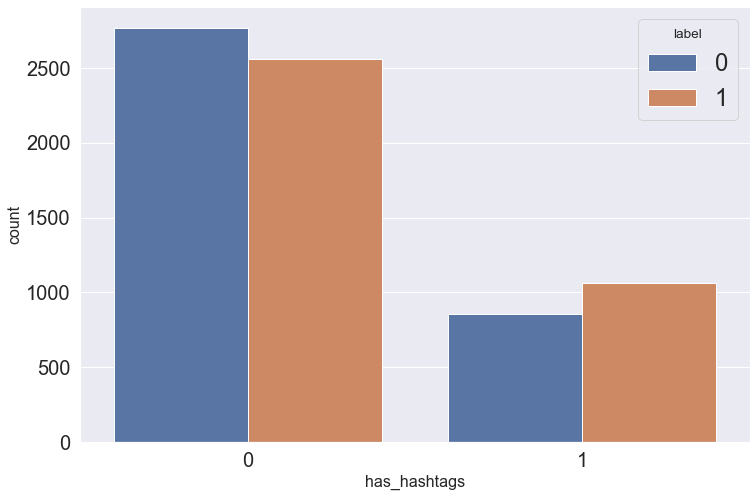



Count plot for ' num_hashtags ' feature, based on Spam/ Ham tweet label


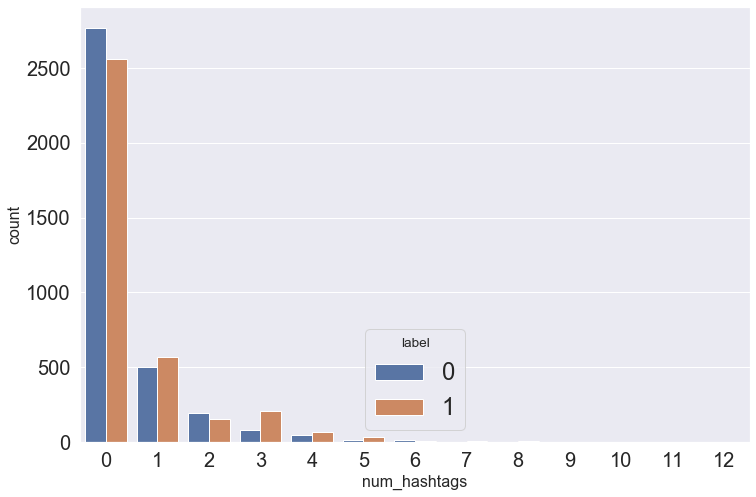



Count plot for ' has_media ' feature, based on Spam/ Ham tweet label


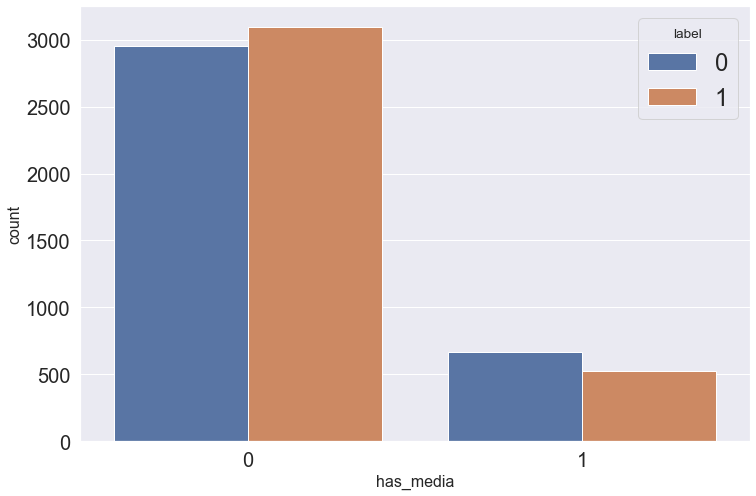



Count plot for ' has_urls ' feature, based on Spam/ Ham tweet label


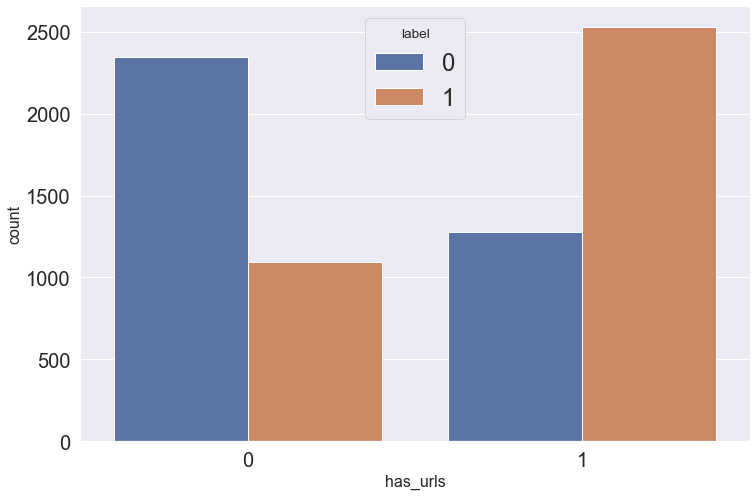



Count plot for ' has_favorite_count ' feature, based on Spam/ Ham tweet label


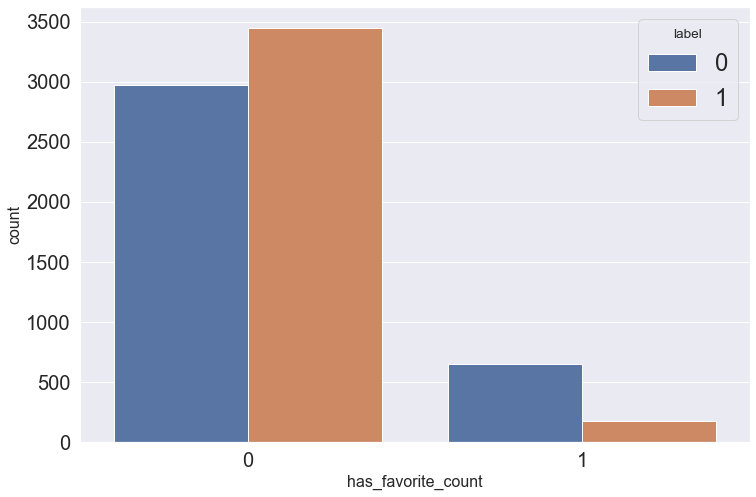



Count plot for ' has_place ' feature, based on Spam/ Ham tweet label


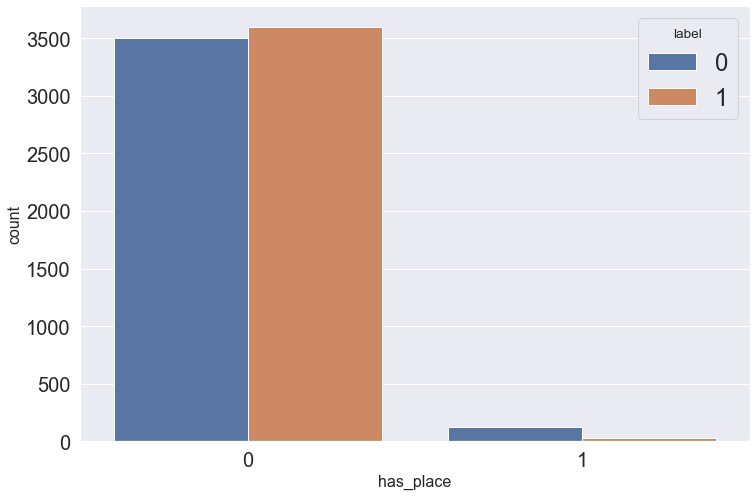



Count plot for ' has_retweet_count ' feature, based on Spam/ Ham tweet label


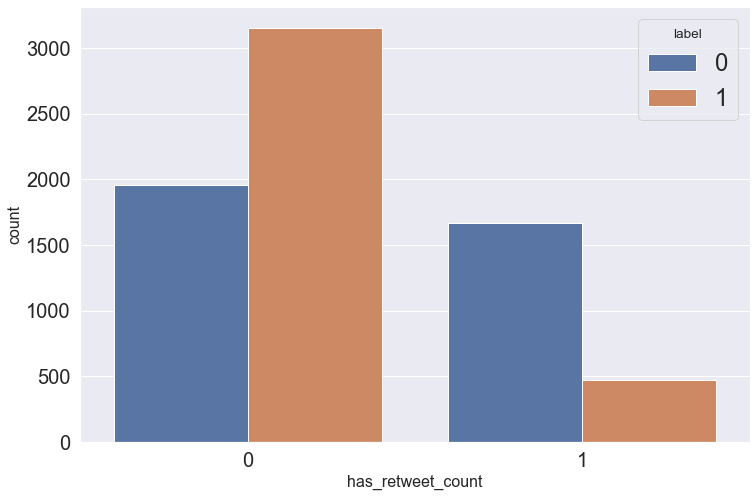



Count plot for ' is_RT ' feature, based on Spam/ Ham tweet label


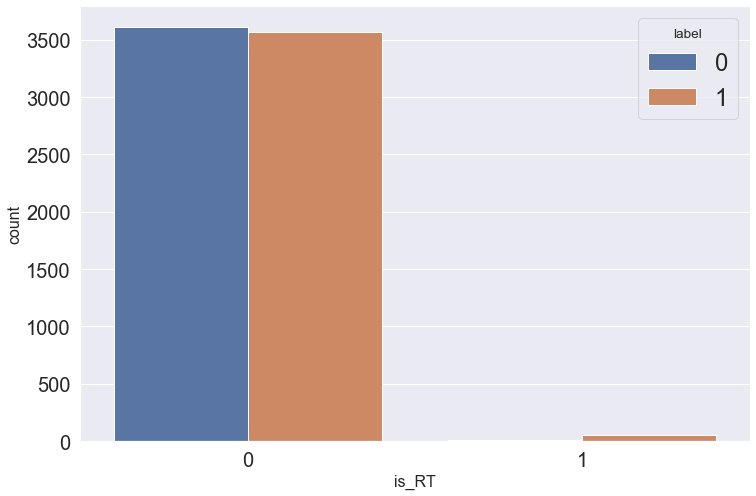



Count plot for ' has_user_description ' feature, based on Spam/ Ham tweet label


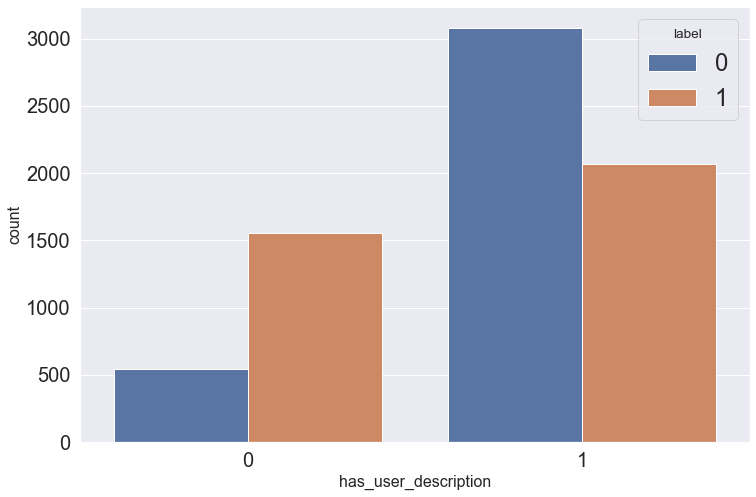



Count plot for ' has_user_name ' feature, based on Spam/ Ham tweet label


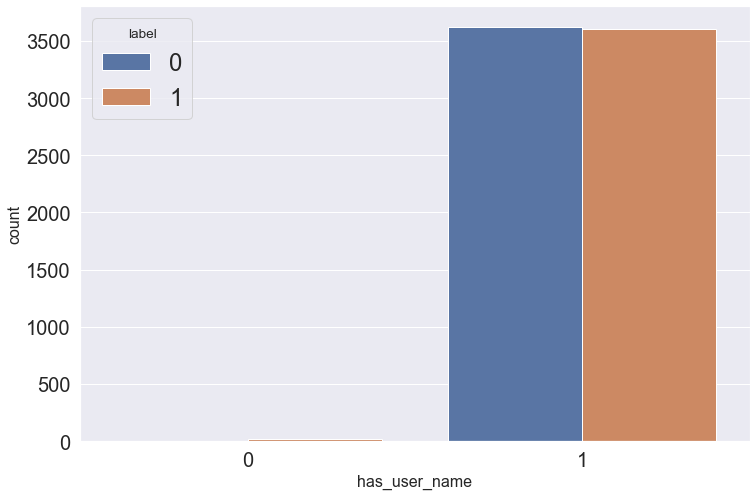



Count plot for ' is_user_verfied ' feature, based on Spam/ Ham tweet label


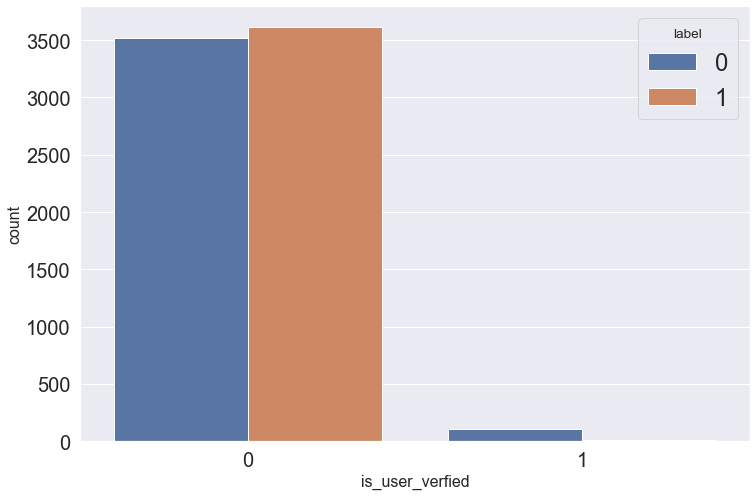



Count plot for ' DIGITS ' feature, based on Spam/ Ham tweet label


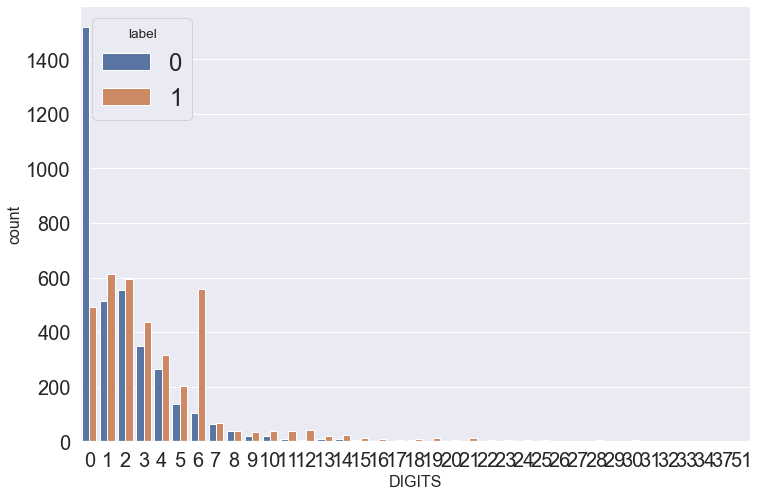



Count plot for ' CAP ' feature, based on Spam/ Ham tweet label


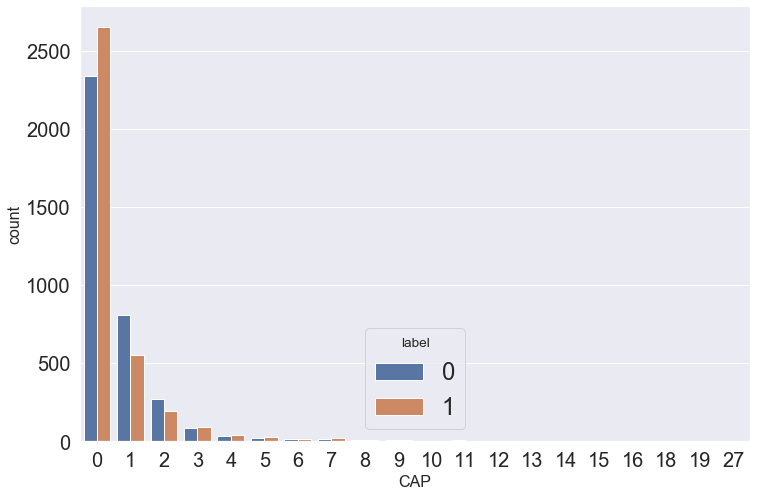

In [53]:
cols = ['label', 'has_hashtags', 'num_hashtags', 'has_media', 'has_urls',
       'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT',
       'has_user_description',  'has_user_name',
        'is_user_verfied',
        'DIGITS', 'CAP']

for i in range(1,len(cols)):
    plt.figure(figsize=(12,8))
    c = cols[i]
    print("Count plot for","'",cols[i],"' feature, based on Spam/ Ham tweet label")
    sns.countplot(c,hue=df.label,data=df)
    plt.show()
    print("\n")

In [54]:
def comfusion_matrix_properties(mat):


    from sklearn.metrics import confusion_matrix

    mat = confusion_matrix(y_test,ypred)
    print("Confusion Matrix:\n\n",mat,"\n")

    TP = mat[0][0]
    FP = mat[0][1]
    FN = mat[1][0]
    TN = mat[1][1]


    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    print("True Positive Rate",round(TPR*100,2),"%")

    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    print("True Negative Rate",round(TNR*100,2),"%")

    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    print("Positive Predictive Value",round(PPV*100,2),"%")

    # Negative predictive value
    NPV = TN/(TN+FN)
    print("Negative Predictive Value",round(NPV*100,2),"%")

    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    print("False Positive Rate",round(FPR*100,2),"%")

    # False negative rate
    FNR = FN/(TP+FN)
    print("False Negative Rate",round(FNR*100,2),"%")

    # False discovery rate
    FDR = FP/(TP+FP)
    print("False Discovery Rate",round(FDR*100,2),"%")


    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    print("Overall Accuracy",round(ACC*100,2),"%")






In [55]:
def roc_curve_plot(input_probabilities,title):
    large = 24

    plt.rc('legend',fontsize=large)
    plt.rc('axes',titlesize = 20)
    plt.rc('axes',labelsize = 16)
    plt.rc('xtick',labelsize = 14)
    plt.rc('ytick',labelsize = 14)
    #plt.set_facecolor('xkcd:white')
    plt.figure(figsize=(12,9))
    y_pred_proba_dt = input_probabilities


    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_dt)
    auc = metrics.roc_auc_score(y_test, y_pred_proba_dt)

    dt_model_object={}
    dt_model_object['fpr']=fpr
    dt_model_object['tpr']=tpr
    dt_model_object['auc']=auc

    plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve: \n'+title)
    plt.legend(loc="lower right")
    plt.grid("off")
    plt.show()

# Modelling & Evaluation

## As a base model, we run a Naive Bayes classifier, purely based on tweet text.

In [56]:
NB_df = df[['filtered_text_lower','label']]
NB_df = NB_df.sample(frac=1)

from sklearn.feature_extraction.text import CountVectorizer

vecfinal = CountVectorizer(min_df=50,max_df=0.8,stop_words="english")
finalX = vecfinal.fit_transform(NB_df['filtered_text_lower'])

### Splitting into training and testing data 

In [57]:
split_limit = round(len(NB_df)/2)
X_train = finalX.toarray()[:split_limit]
X_test = finalX.toarray()[split_limit:]
y_train = NB_df.label[:split_limit]
y_test = NB_df.label[split_limit:]

###  Applying Bernoulli Naive Bayes Model

In [58]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

clf_nb = BernoulliNB()
clf_nb.fit(X_train, y_train)
ypred = clf_nb.predict(X_test)
ypred_NB_model=clf_nb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')
print("Accuracy for this model: ", accuracy*100,"%")

Accuracy for this model:  78.68932379057242 %


In [59]:
print("Naive Bayes Model ")
mat = confusion_matrix(y_test,ypred)
comfusion_matrix_properties(mat)

Naive Bayes Model 
Confusion Matrix:

 [[1751   77]
 [ 673 1122]] 

True Positive Rate 72.24 %
True Negative Rate 93.58 %
Positive Predictive Value 95.79 %
Negative Predictive Value 62.51 %
False Positive Rate 6.42 %
False Negative Rate 27.76 %
False Discovery Rate 4.21 %
Overall Accuracy 79.3 %


### Below are the AUC & ROC's of the Bernoulli Naive Bayes model

ROC performance for Naive Bayes is better than the other models

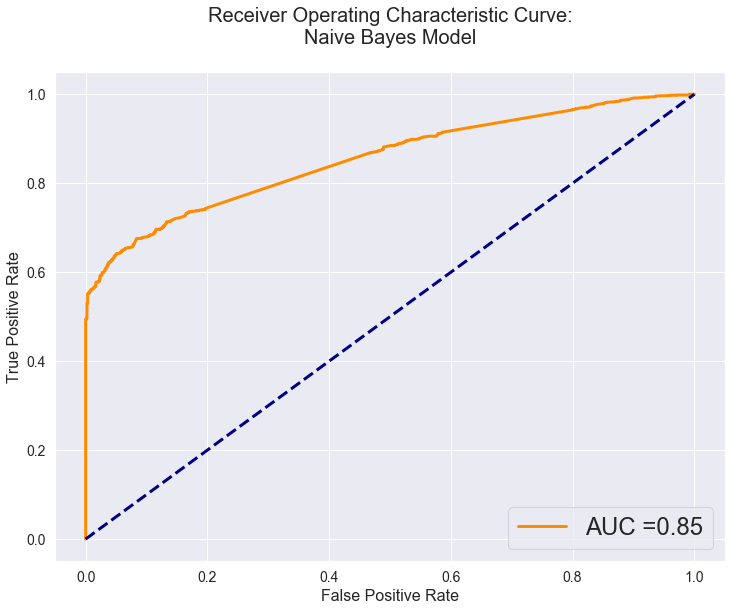

In [60]:
large = 24

from sklearn import metrics
plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn = clf_nb.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

naive_bayes_model_object={}
naive_bayes_model_object['fpr']=fpr
naive_bayes_model_object['tpr']=tpr
naive_bayes_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nNaive Bayes Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

As we can see from the graph, our ROC curve looks good i.e. for a given FPR the TPR is fairly good enough.

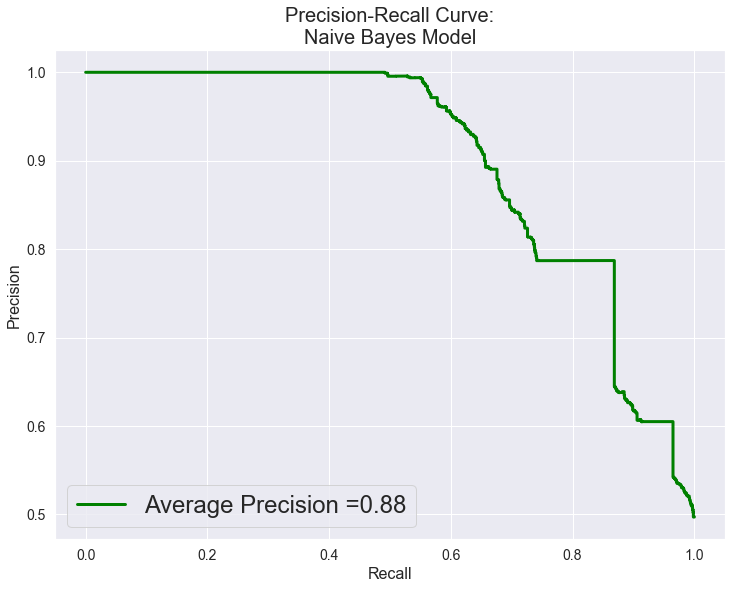

In [61]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


y_pred_proba_nb=clf_nb.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_nb)
average_precision = average_precision_score(y_test, y_pred_proba_nb)

large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

naive_bayes_model_object['recall']=recall
naive_bayes_model_object['precision']=precision
naive_bayes_model_object['average_precision']=average_precision

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nNaive Bayes Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

### Applying Multinomial Naive Bayes Model 

In [62]:
from sklearn.naive_bayes import MultinomialNB
clf_mnb = MultinomialNB()
clf_mnb.fit(X_train, y_train)
ypred = clf_mnb.predict(X_test)
ypred_MultinomialNB_model=clf_mnb.predict(X_test)
accuracy = f1_score(y_test, ypred, average='weighted')
print("Accuracy for this model: ", accuracy*100,"%")

Accuracy for this model:  68.72980096424985 %


In [63]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test,ypred)
print("Confusion Matrix:\n\n",mat,"\n")

Confusion Matrix:

 [[1306  522]
 [ 610 1185]] 



In [64]:
comfusion_matrix_properties(mat)

Confusion Matrix:

 [[1306  522]
 [ 610 1185]] 

True Positive Rate 68.16 %
True Negative Rate 69.42 %
Positive Predictive Value 71.44 %
Negative Predictive Value 66.02 %
False Positive Rate 30.58 %
False Negative Rate 31.84 %
False Discovery Rate 28.56 %
Overall Accuracy 68.76 %


### Below are the AUC & ROC's of the Multinomial Naive Bayes model 

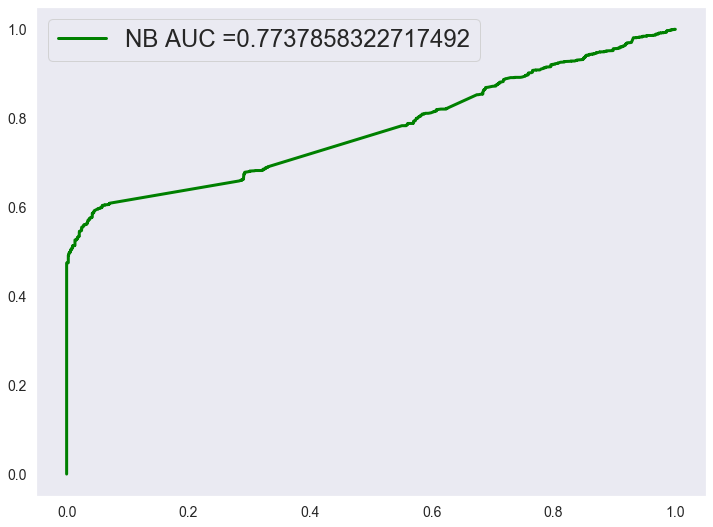

In [65]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(12,9))
y_pred_proba_mnb = clf_mnb.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_mnb)
auc = metrics.roc_auc_score(y_test, y_pred_proba_mnb)
multinomial_naive_bayes_model_object={}
multinomial_naive_bayes_model_object['fpr']=fpr
multinomial_naive_bayes_model_object['tpr']=tpr
multinomial_naive_bayes_model_object['auc']=auc

plt.plot(fpr,tpr,label="NB AUC ="+str(auc), lw=3,color='green')

plt.legend()
plt.grid()
plt.show()

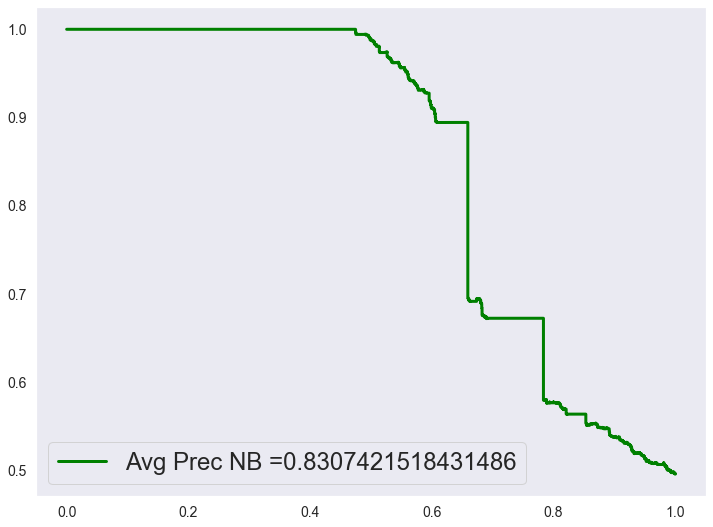

In [66]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_mnb)
average_precisionn = average_precision_score(y_test, y_pred_proba_mnb)
plt.figure(figsize=(12,9))
plt.step(recall, precision, color='green',label="Avg Prec NB ="+str(average_precisionn),lw=3)


plt.legend()
plt.grid()
plt.show()

## Now, we would like to see how the non-text based features work for prediction 

## We subset only necessary features which make sense in this scenario, i.e., features that statistically differentiate between spam and ham tweets.

In [67]:
y = df.label
X = df[['has_hashtags', 'num_hashtags', 'has_media','user_favourites_count',
       'has_urls', 'has_favorite_count', 'has_place', 'has_retweet_count',
       'is_RT', 'has_user_description', 'has_user_followers_count',
       'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
       'length', 'DIGITS', 'CAP','user_listed_count']]


# Index(['id', 'label', 'created_at', 'hashtags', 'media', 'urls',
#        'favorite_count', 'in_reply_to_screen_name', 'in_reply_to_status_id',
#        'in_reply_to_user_id', 'place', 'possibly_sensitive', 'quote_id',
#        'retweet_count', 'retweet_id', 'retweet_screen_name', 'source', 'text',
#        'tweet_url', 'user_created_at', 'user_id', 'user_default_profile_image',
#        'user_description', 'user_favourites_count', 'user_followers_count',
#        'user_friends_count', 'user_listed_count', 'user_location', 'user_name',
#        'user_screen_name', 'user_statuses_count', 'user_time_zone',
#        'user_urls', 'user_verified', 'tweet_day', 'tweet_month', 'tweet_date',
#        'tweet_time', 'tweet_year', 'acc_created_day', 'acc_created_month',
#        'acc_created_date', 'acc_created_time', 'acc_created_year',
#        'has_hashtags', 'num_hashtags', 'has_media', 'has_urls',
#        'has_favorite_count', 'has_place', 'has_retweet_count', 'is_RT',
#        'has_user_description', 'has_user_followers_count',
#        'has_user_listed_count', 'has_user_name', 'is_user_verfied', 'f_ratio',
#        'length', 'DIGITS', 'CAP', 'filtered_text', 'filtered_text_lower',
#        'polarity', 'subjectivity', 'sentiment_flag', 'subjectivity_flag'],
#       dtype='object')



model = X

### Prediction using Decision Tree Classifier 

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(model, y, test_size = 0.2,random_state=0)

depth = []
training_score = []
testing_score = []

for i in range(1,25):
    clf_dt = DecisionTreeClassifier(criterion = "gini",random_state=0)
    clf_dt.max_depth = i
    clf_dt.fit(X_train, y_train)
    pred_train = clf_dt.predict(X_train)
    #print("Training accuracy, with",i,"depth :",accuracy_score(pred_train,y_train)*100)
    
    pred_test = clf_dt.predict(X_test)
    #print("Testing accuracy, with",i,"depth :",accuracy_score(pred_test,y_test)*100,"\n")
    
    depth.append(i)
    training_score.append(accuracy_score(pred_train,y_train))
    testing_score.append(accuracy_score(pred_test,y_test))

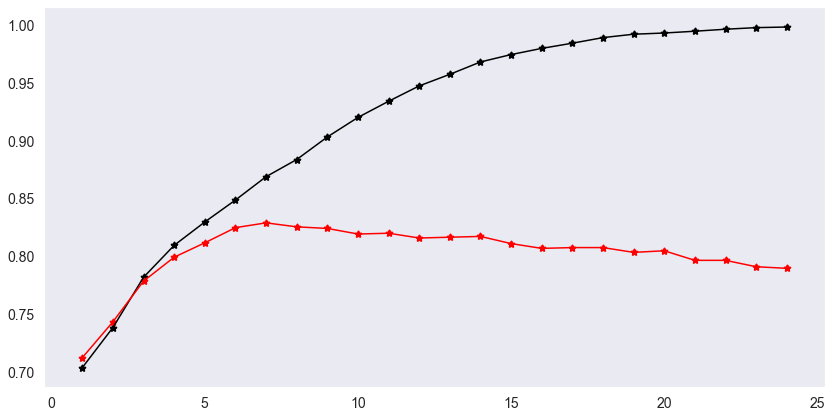

In [69]:
plt.figure(figsize=(14,7))
plt.grid()

plt.plot(depth, training_score,c='black')
plt.plot(depth, testing_score,c='red')
plt.scatter(depth, training_score,c='black',marker='*',linewidth=2)
plt.scatter(depth, testing_score,c='red',marker='*',linewidth=2)

### We observe that the model predicts well for a maximum tree depth from 6 to 9, with accuracy of around 81 %

from pandas.compat import StringIO
from sklearn import tree
import pydotplus


dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("train.pdf") 

from IPython.display import IFrame
IFrame("train.pdf", width=900, height=450)

### Now, we find optimal parameters using Grid Serach 

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0)
    
clf = DecisionTreeClassifier(random_state=0)
 
param_grid = {
              "criterion": ["gini", "entropy"],
              "max_depth": list(np.arange(1,50,1)),
              }
 
CLF = GridSearchCV(estimator = clf, param_grid=param_grid, cv = 5)
CLF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=0, splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10

### The best parameters are as follows: 

In [71]:
CLF.best_params_

{'criterion': 'entropy', 'max_depth': 7}

### Now, we fit a new model with the best parameters 

In [72]:
clf_dt = DecisionTreeClassifier(criterion=CLF.best_params_['criterion'],max_depth=CLF.best_params_['max_depth'],random_state=0)
clf_dt.fit(X_train,y_train)
ypred = clf_dt.predict(X_test)
ypred_DT_model=clf_dt.predict(X_test)
print("Prediction Accuracy:",accuracy_score(ypred,y_test)*100,"%")

Prediction Accuracy: 82.55172413793103 %


In [73]:
comfusion_matrix_properties(mat)

Confusion Matrix:

 [[589 135]
 [118 608]] 

True Positive Rate 83.31 %
True Negative Rate 81.83 %
Positive Predictive Value 81.35 %
Negative Predictive Value 83.75 %
False Positive Rate 18.17 %
False Negative Rate 16.69 %
False Discovery Rate 18.65 %
Overall Accuracy 82.55 %


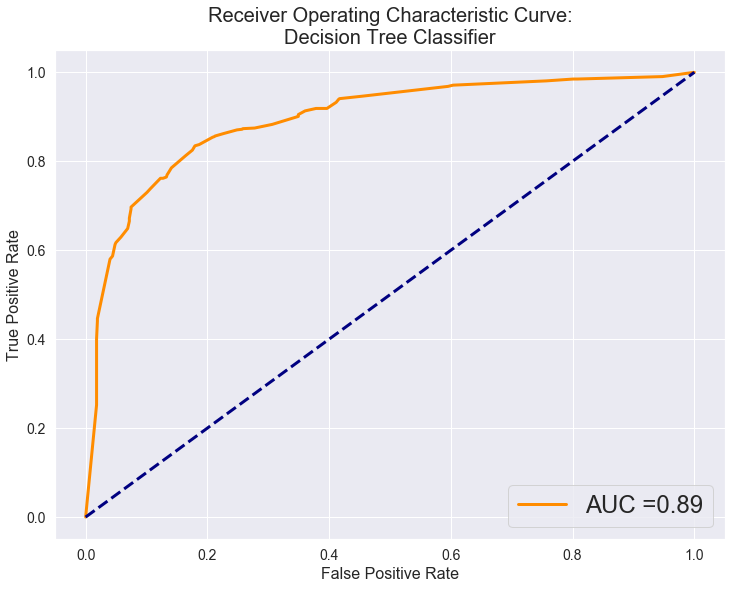

In [74]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn =clf_dt.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

dt_model_object={}
dt_model_object['fpr']=fpr
dt_model_object['tpr']=tpr
dt_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nDecision Tree Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

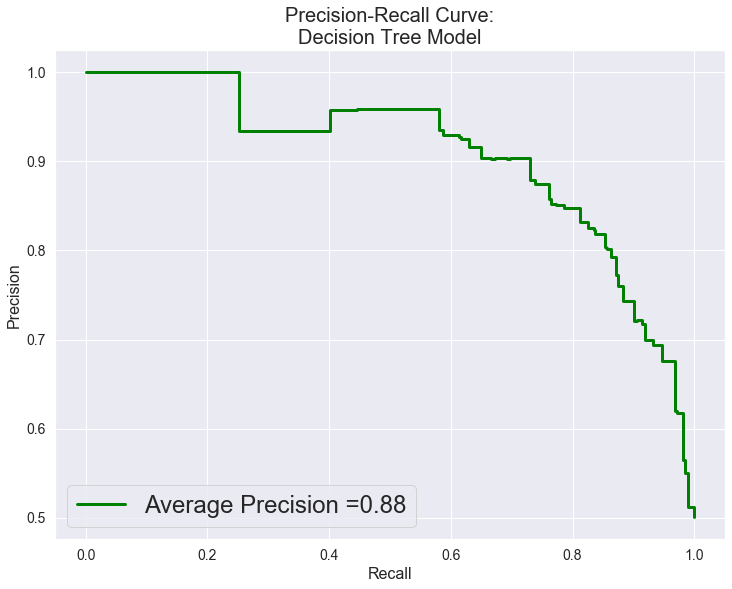

In [75]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_dt =clf_dt.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_dt)
average_precision = average_precision_score(y_test, y_pred_proba_dt)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
dt_model_object['recall']=recall
dt_model_object['precision']=precision
dt_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nDecision Tree Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

### Applying KNN model and tuning hyper-parameter

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X = model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
    
neigh = KNeighborsClassifier()

k = np.arange(20)+1
param_grid = {'n_neighbors': k}
                                  
CLF = GridSearchCV(estimator = neigh, param_grid = param_grid, cv = 5)
CLF.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [77]:
CLF.best_params_

{'n_neighbors': 12}

In [78]:
neigh = KNeighborsClassifier(n_neighbors = CLF.best_params_['n_neighbors'])
neigh.fit(X_train,y_train)
ypred = neigh.predict(X_test)
ypred_knn_model=neigh.predict(X_test)
accuracy_score(ypred,y_test)*100

72.89655172413792

In [79]:
comfusion_matrix_properties(mat)

Confusion Matrix:

 [[581 143]
 [250 476]] 

True Positive Rate 69.92 %
True Negative Rate 76.9 %
Positive Predictive Value 80.25 %
Negative Predictive Value 65.56 %
False Positive Rate 23.1 %
False Negative Rate 30.08 %
False Discovery Rate 19.75 %
Overall Accuracy 72.9 %


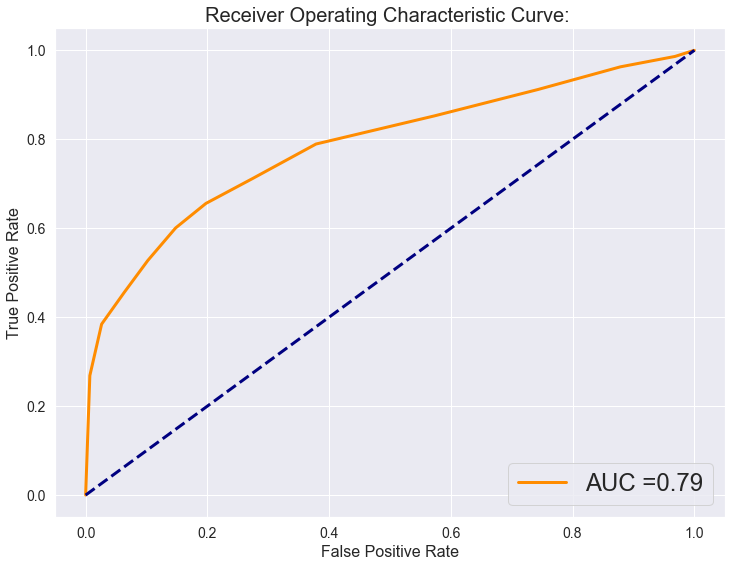

In [80]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_knn)
auc = metrics.roc_auc_score(y_test, y_pred_proba_knn)

knn_model_object={}
knn_model_object['fpr']=fpr
knn_model_object['tpr']=tpr
knn_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: ')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

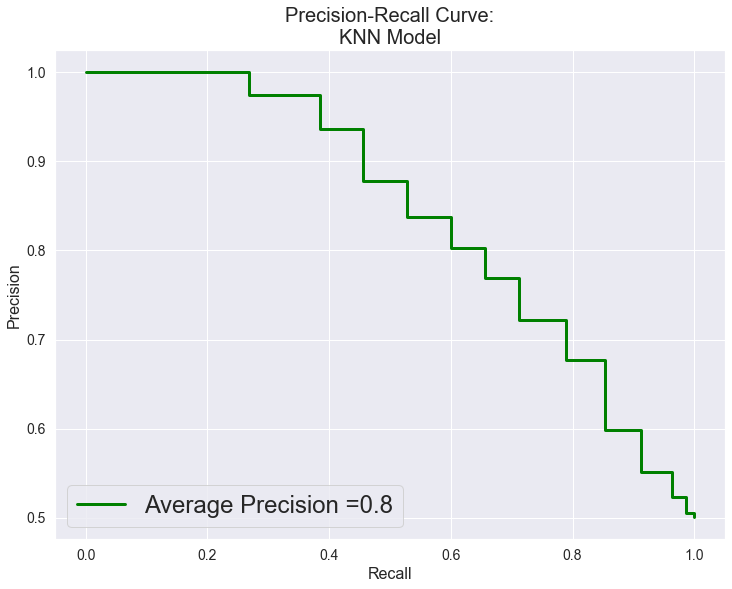

In [81]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_knn = neigh.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_knn)
average_precision = average_precision_score(y_test, y_pred_proba_knn)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
knn_model_object['recall']=recall
knn_model_object['precision']=precision
knn_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nKNN Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

### Here, we use a random Forest Classifier, which generally tends to perform better than a Decision Tree Classfifier 

In [82]:
from sklearn.ensemble import RandomForestClassifier
print("RANDOM FOREST CLASSIFIER")

rfc = RandomForestClassifier(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=0)

rfc.fit(X_train,y_train)
ypred = rfc.predict(X_test)
ypred_rfc_model=rfc.predict(X_test)
print("Prediction Accuracy:",round(accuracy_score(ypred,y_test)*100,2),"%")


mat = confusion_matrix(y_test,ypred)

print(comfusion_matrix_properties(mat))
print()

print("Feature importances:")
print(rfc.feature_importances_)


RANDOM FOREST CLASSIFIER
Prediction Accuracy: 85.17 %
Confusion Matrix:

 [[627  97]
 [118 608]] 

True Positive Rate 84.16 %
True Negative Rate 86.24 %
Positive Predictive Value 86.6 %
Negative Predictive Value 83.75 %
False Positive Rate 13.76 %
False Negative Rate 15.84 %
False Discovery Rate 13.4 %
Overall Accuracy 85.17 %
None

Feature importances:
[0.0106935  0.02388925 0.0143012  0.18691685 0.08587796 0.01480601
 0.00400486 0.07556112 0.00696349 0.02758854 0.         0.
 0.00101538 0.00300151 0.11136687 0.15696707 0.10540726 0.03846001
 0.1331791 ]


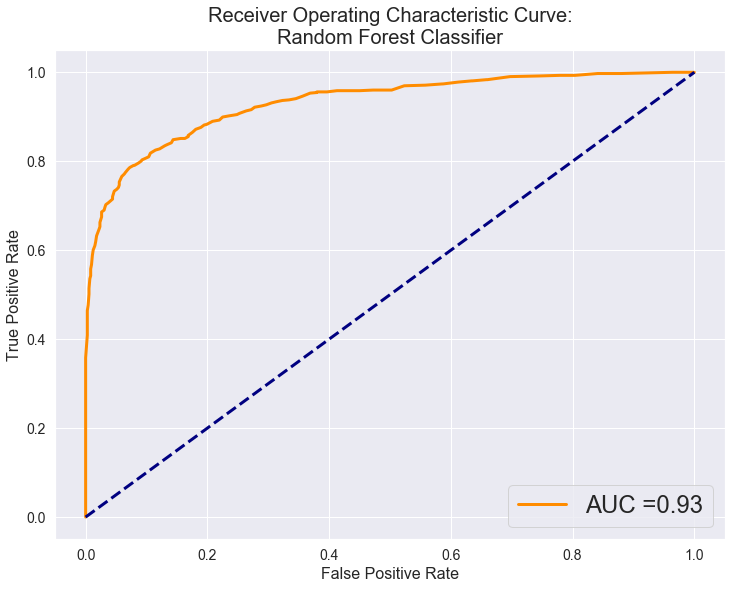

In [83]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)
#plt.set_facecolor('xkcd:white')
plt.figure(figsize=(12,9))
y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
variable2=y_pred_proba_knn

fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_rfc)
auc = metrics.roc_auc_score(y_test, y_pred_proba_rfc)

rfc_model_object={}
rfc_model_object['fpr']=fpr
rfc_model_object['tpr']=tpr
rfc_model_object['auc']=auc

plt.plot(fpr,tpr,label="AUC ="+str(round(auc,2)), lw=3,color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve:\nRandom Forest Classifier')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

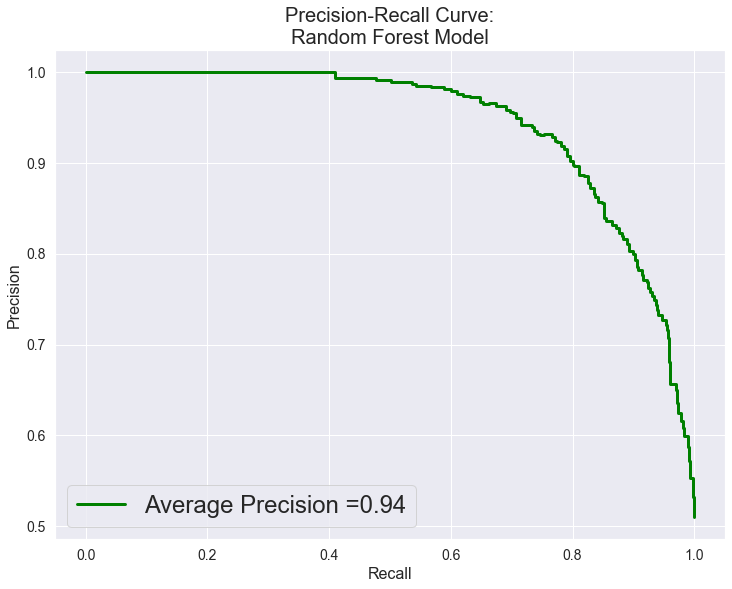

In [84]:
large = 24

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))

y_pred_proba_rfc = rfc.predict_proba(X_test)[:,1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_rfc)
average_precision = average_precision_score(y_test, y_pred_proba_rfc)

plt.step(recall, precision, color='green',label="Average Precision ="+str(round(average_precision,2)),lw=3)
rfc_model_object['recall']=recall
rfc_model_object['precision']=precision
rfc_model_object['average_precision']=average_precision

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve:\nRandom Forest Model')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

### Feature Importances for classifier

In [85]:
for i in range(len(rfc.feature_importances_)):
    print(X_train.columns[i],rfc.feature_importances_[i])

has_hashtags 0.010693498102544753
num_hashtags 0.02388925443662855
has_media 0.014301203000911318
user_favourites_count 0.1869168502398894
has_urls 0.08587796191936638
has_favorite_count 0.014806006567219358
has_place 0.0040048584192135415
has_retweet_count 0.07556112304150361
is_RT 0.0069634898635800215
has_user_description 0.027588544600860198
has_user_followers_count 0.0
has_user_listed_count 0.0
has_user_name 0.001015380868747675
is_user_verfied 0.00300151405509146
f_ratio 0.11136686626493372
length 0.15696707017936318
DIGITS 0.10540726329294291
CAP 0.03846001067216521
user_listed_count 0.1331791044750387


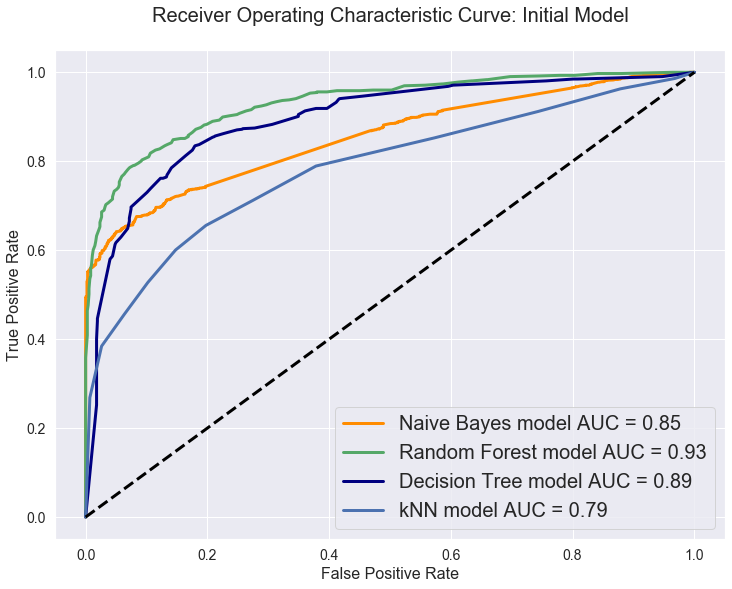

In [86]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))


plt.plot(naive_bayes_model_object['fpr'],naive_bayes_model_object['tpr'],label="Naive Bayes model AUC = "+str(round(naive_bayes_model_object['auc'],2)), lw=3,color='darkorange')

plt.plot(rfc_model_object['fpr'],rfc_model_object['tpr'],label="Random Forest model AUC = "+str(round(rfc_model_object['auc'],2)), lw=3,color='g')



plt.plot(dt_model_object['fpr'],dt_model_object['tpr'],label="Decision Tree model AUC = "+str(round(dt_model_object['auc'],2)), lw=3,color='navy')
plt.plot(knn_model_object['fpr'],knn_model_object['tpr'],label="kNN model AUC = "+str(round(knn_model_object['auc'],2)), lw=3,color='b')


plt.plot([0, 1], [0, 1], color='black', lw=3, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve: Initial Model\n')
plt.legend(loc="lower right")
plt.grid("off")
plt.show()

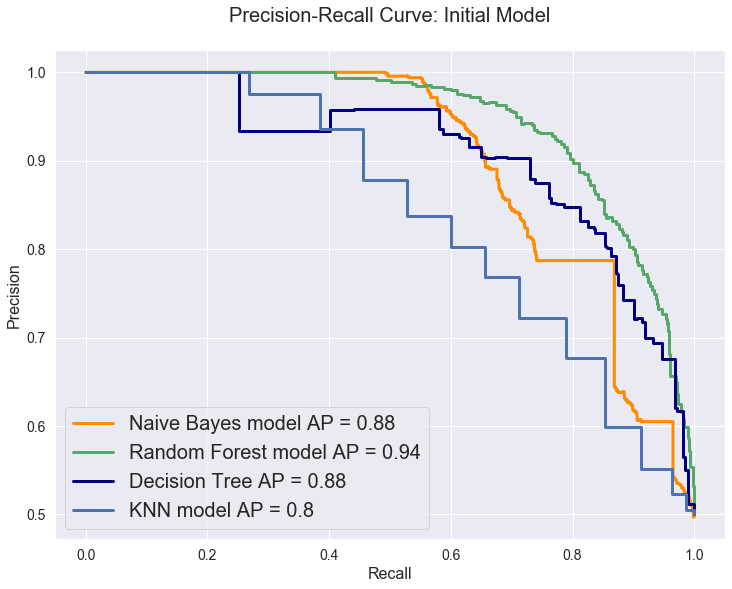

In [87]:
large = 20

plt.rc('legend',fontsize=large)
plt.rc('axes',titlesize = 20)
plt.rc('axes',labelsize = 16)
plt.rc('xtick',labelsize = 14)
plt.rc('ytick',labelsize = 14)

plt.figure(figsize=(12,9))



plt.step(naive_bayes_model_object['recall'], naive_bayes_model_object['precision'], color='darkorange',label="Naive Bayes model AP = "+str(round(naive_bayes_model_object['average_precision'],2)),lw=3)
plt.step(rfc_model_object['recall'], rfc_model_object['precision'], color='g',label="Random Forest model AP = "+str(round(rfc_model_object['average_precision'],2)),lw=3)
plt.step(dt_model_object['recall'], dt_model_object['precision'], color='navy',label="Decision Tree AP = "+str(round(dt_model_object['average_precision'],2)),lw=3)
plt.step(knn_model_object['recall'], knn_model_object['precision'], color='b',label="KNN model AP = "+str(round(knn_model_object['average_precision'],2)),lw=3)


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Initial Model\n')
plt.legend(loc="lower left")
plt.grid("off")
plt.show()

In conclusion, Naive bayes model gives better performance in terms of false positive rate among the considered models.